In [1]:
import pandas as pd
df=pd.read_csv("C:/Users/LAKSHMI CHARISHMA/Documents/AQI prediction/data/cleaned/cleaned_dataset.csv")
df.head()

,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,uv_index,gust_kph,...,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,hour,day_of_week,month,is_weekend,part_of_day
0,26.6,13.3,338,1012.0,0.0,24,30,10.0,7.0,15.3,...,1.1,0.2,8.40,26.6,1,13,3,5,0,afternoon
1,19.0,11.2,320,1012.0,0.1,94,75,10.0,5.0,18.4,...,0.9,0.1,1.10,2.0,1,10,3,5,0,morning
2,23.0,15.1,280,1011.0,0.0,29,0,10.0,5.0,22.3,...,65.1,13.4,10.40,18.4,1,9,3,5,0,morning
3,6.3,11.9,215,1007.0,0.3,61,100,2.0,2.0,13.7,...,1.6,0.2,0.70,0.9,1,10,3,5,0,morning
4,26.0,13.0,150,1011.0,0.0,89,50,10.0,8.0,20.2,...,72.7,31.5,177.97,262.3,5,9,3,5,0,morning


IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

Training AQI classification model

In [ ]:
class AQIPredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.label_encoder = None
        self.feature_names = None
        
        # AQI category mapping
        self.aqi_categories = {
            1: {"name": "Good", "color": "#00E400", "description": "Air quality is satisfactory."},
            2: {"name": "Moderate", "color": "#FFFF00", "description": "Acceptable air quality."},
            3: {"name": "Unhealthy for Sensitive Groups", "color": "#FF7E00", "description": "Members of sensitive groups may experience health effects."},
            4: {"name": "Unhealthy", "color": "#FF0000", "description": "Everyone may begin to experience health effects."},
            5: {"name": "Very Unhealthy", "color": "#8F3F97", "description": "Health alert: everyone may experience more serious health effects."},
            6: {"name": "Hazardous", "color": "#7E0023", "description": "Health warning of emergency conditions."}
        }
    
    def prepare_data(self, df):
        """Prepare data for training"""
        data = df.copy()
        
        # Encode categorical variables
        le = LabelEncoder()
        data['part_of_day'] = le.fit_transform(data['part_of_day'])
        
        # Select features (based on your dataset columns)
        self.feature_names = [
            'temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb',
            'precip_mm', 'humidity', 'cloud', 'visibility_km', 'uv_index',
            'gust_kph', 'hour', 'day_of_week', 'month', 'is_weekend', 'part_of_day'
        ]
        
        X = data[self.feature_names]
        
        # Encode target variable
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(data['air_quality_us-epa-index'])
        
        return X, y
    
    def train(self, X, y):
        """Train the production model"""
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Optimized Random Forest model
        self.model = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        # Train model
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Production Model Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        return accuracy
    
    def save_models(self, filename_prefix='aqi_model'):
        """Save all model artifacts"""
        joblib.dump(self.model, f'{filename_prefix}_predictor.pkl')
        joblib.dump(self.scaler, f'{filename_prefix}_scaler.pkl')
        joblib.dump(self.label_encoder, f'{filename_prefix}_encoder.pkl')
        joblib.dump(self.feature_names, f'{filename_prefix}_features.pkl')
        print("All model artifacts saved successfully!")
    
    def load_models(self, filename_prefix='aqi_model'):
        """Load saved model artifacts"""
        self.model = joblib.load(f'{filename_prefix}_predictor.pkl')
        self.scaler = joblib.load(f'{filename_prefix}_scaler.pkl')
        self.label_encoder = joblib.load(f'{filename_prefix}_encoder.pkl')
        self.feature_names = joblib.load(f'{filename_prefix}_features.pkl')
        print("Models loaded successfully!")
    
    def predict(self, weather_data, confidence_threshold=0.6):
        """Make prediction for website usage"""
        try:
            # Prepare input data with default values
            input_features = {}
            for feature in self.feature_names:
                input_features[feature] = weather_data.get(feature, 0)
            
            input_df = pd.DataFrame([input_features])
            input_scaled = self.scaler.transform(input_df)
            
            # Get prediction and probabilities
            prediction_encoded = self.model.predict(input_scaled)[0]
            probabilities = self.model.predict_proba(input_scaled)[0]
            confidence = np.max(probabilities)
            
            # Convert to original label
            prediction_original = self.label_encoder.inverse_transform([prediction_encoded])[0]
            
            # Get category info
            category_info = self.aqi_categories[prediction_original]
            
            return {
                'success': True,
                'aqi_category': int(prediction_original),
                'category_name': category_info['name'],
                'category_color': category_info['color'],
                'description': category_info['description'],
                'confidence': float(confidence),
                'is_high_confidence': confidence >= confidence_threshold,
                'probabilities': {
                    self.aqi_categories[i+1]['name']: float(prob) 
                    for i, prob in enumerate(probabilities)
                }
            }
            
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'message': 'Prediction failed'
            }

# Train and save the model
def train_and_save_model(df):
    predictor = AQIPredictor()
    X, y = predictor.prepare_data(df)
    accuracy = predictor.train(X, y)
    predictor.save_models()
    return predictor

# Load trained model for predictions
def load_trained_model():
    predictor = AQIPredictor()
    predictor.load_models()
    return predictor

if __name__ == "__main__":
    print("🚀 Training and saving the model...")
    predictor = train_and_save_model(df)
    print("✅ Model trained and saved successfully!")
    # Example prediction
    example_weather = {
        'temperature_celsius': 25.0,
        'wind_kph': 15.0,
        'wind_degree': 180.0,
        'pressure_mb': 1010.0,
        'precip_mm': 0.0,
        'humidity': 60.0,
        'cloud': 30.0,
        'visibility_km': 10.0,
        'uv_index': 5.0,
        'gust_kph': 20.0,
        'hour': 14.0,
        'day_of_week': 3.0,
        'month': 6.0,
        'is_weekend': 0.0,
        'part_of_day': 1.0  # afternoon
    }
    
    prediction = predictor.predict(example_weather)
    if prediction['success']:
        print(f"\n🎯 Prediction Result:")
        print(f"Predicted AQI: {prediction['category_name']}")
        print(f"Confidence: {prediction['confidence']:.2%}")
        print(f"Description: {prediction['description']}")
    else:
        print(f"❌ Error: {prediction['error']}")

🚀 Training and saving the model...
Production Model Accuracy: 0.6854

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      9267
           1       0.60      0.63      0.61      5789
           2       0.43      0.31      0.36      1632
           3       0.52      0.50      0.51      1209
           4       0.49      0.30      0.37       193
           5       0.58      0.37      0.45        78

    accuracy                           0.69     18168
   macro avg       0.57      0.49      0.52     18168
weighted avg       0.68      0.69      0.68     18168

All model artifacts saved successfully!
✅ Model trained and saved successfully!

🎯 Prediction Result:
Predicted AQI: Good
Confidence: 70.67%
Description: Air quality is satisfactory.


Training PM2.5 regression model

In [9]:
def build_pm25_regression_model(df):
    """Build and save PM2.5 regression model"""
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import joblib
    
    # Prepare features (same as classification)
    features = ['temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb',
               'precip_mm', 'humidity', 'cloud', 'visibility_km', 'uv_index',
               'gust_kph', 'hour', 'day_of_week', 'month', 'is_weekend', 'part_of_day']
    
    # Encode categorical
    df = df.copy()
    le = LabelEncoder()
    df['part_of_day'] = le.fit_transform(df['part_of_day'])
    
    X = df[features]
    y = df['air_quality_PM2.5']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestRegressor(
        n_estimators=150,
        max_depth=25,
        min_samples_split=3,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"PM2.5 Regression Model:")
    print(f"MSE: {mse:.2f}, R²: {r2:.4f}")
    
    # Save model
    joblib.dump(model, 'pm25_regression_model.pkl')
    joblib.dump(scaler, 'pm25_scaler.pkl')
    joblib.dump(features, 'pm25_features.pkl')
    
    return model, mse, r2

# Build it now!
pm25_model, mse, r2 = build_pm25_regression_model(df)

PM2.5 Regression Model:
MSE: 382.77, R²: 0.5903


Training Forecated AQI (24hr) Regression model

🚀 Training 24-hour AQI forecast model...
Training forecast model...
Preparing forecast data...
Using 54 features for forecasting
Final dataset shape: (90766, 68)
Train shape: (72612, 54), Test shape: (18154, 54)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


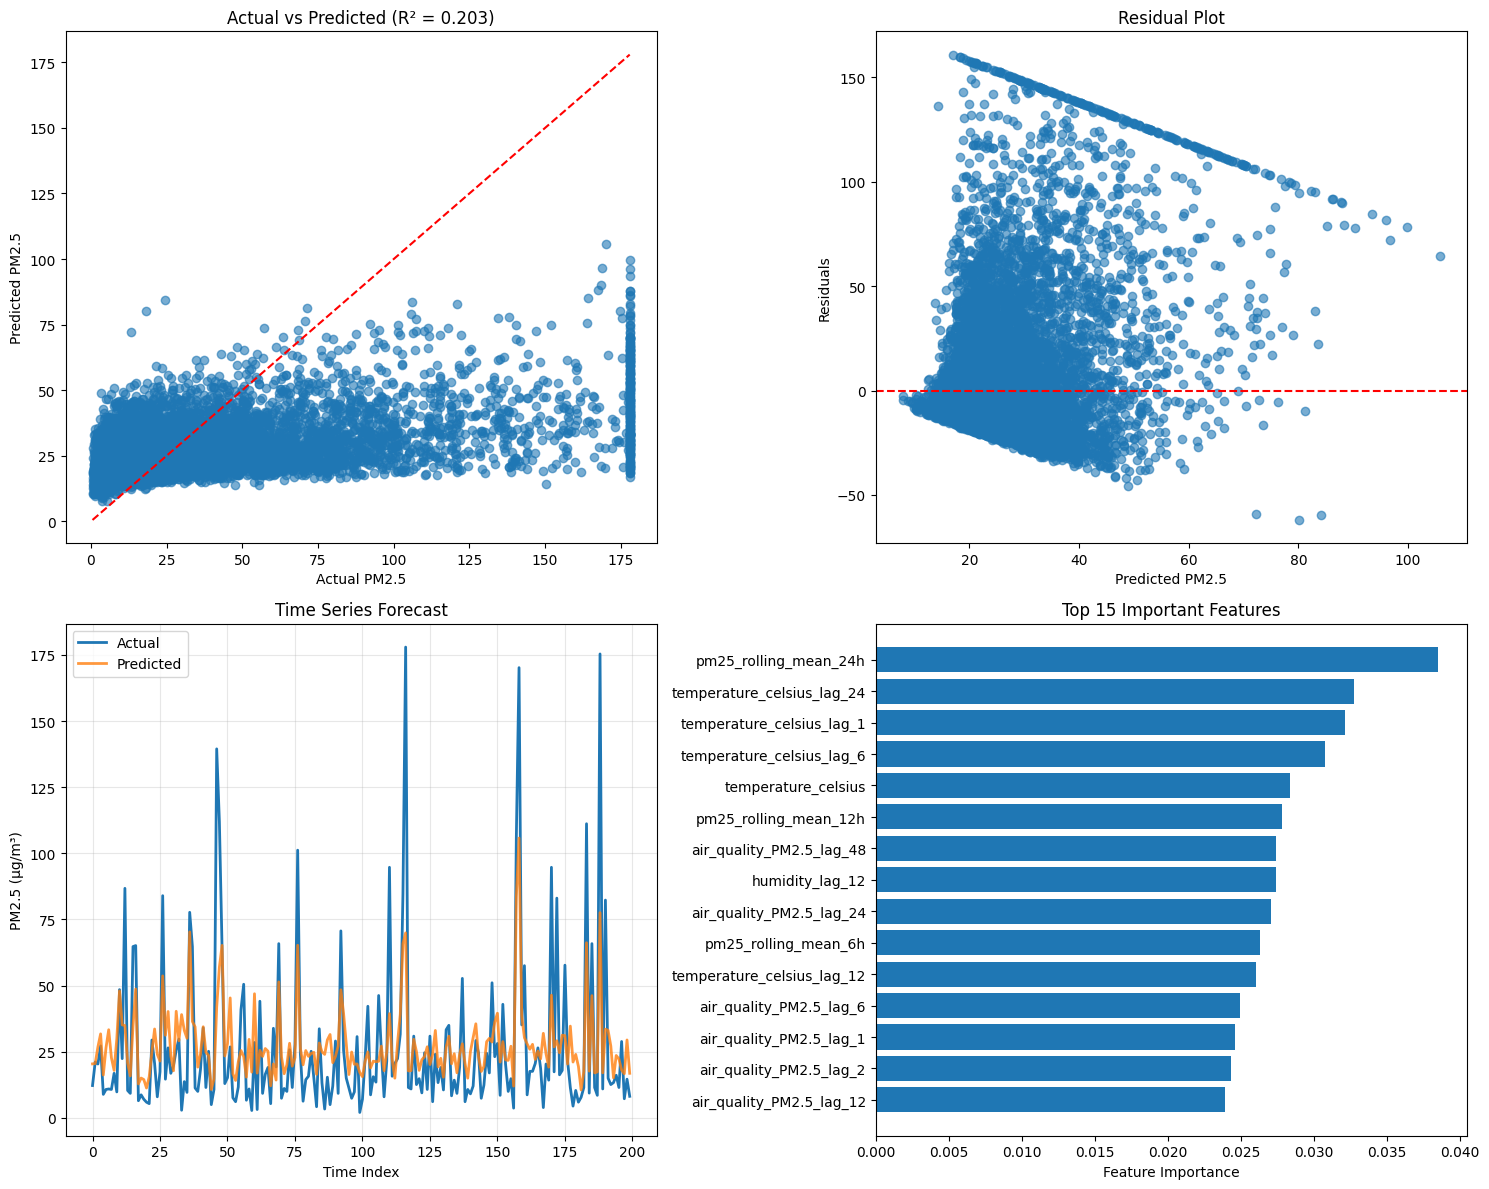


FORECAST MODEL PERFORMANCE METRICS
R² Score: 0.2032
MAE: 16.21 μg/m³
RMSE: 26.22 μg/m³
MAPE: 116.78%
Direction Accuracy: 63.15%
Model saved as aqi_forecast_24h_*.pkl

🎯 Example Prediction:
Current PM2.5: 35.0 μg/m³
Predicted PM2.5 in 24h: 44.8 μg/m³
Predicted AQI: 3 (Unhealthy for Sensitive Groups)
Trend: ↓ Worsening


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [ ]:
class AQIForecaster:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.target_column = 'air_quality_PM2.5'
        
    def create_time_features(self, df):
        """Create advanced time-based features"""
        df = df.copy()
        
        # DateTime features (if you have timestamp)
        if 'timestamp' not in df.columns:
            # Create synthetic timestamp assuming hourly data
            df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')
        
        # Cyclical time features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        
        # Time of day categories
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 19))
        df['is_rush_hour'] = df['is_rush_hour'].astype(int)
        
        return df
    
    def create_lag_features(self, df, lags=[1, 2, 3, 6, 12, 24, 48]):
        """Create lag features for target and important predictors"""
        df = df.copy()
        
        # Lag features for target variable
        for lag in lags:
            df[f'{self.target_column}_lag_{lag}'] = df[self.target_column].shift(lag)
        
        # Lag features for key weather variables
        weather_vars = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm']
        for var in weather_vars:
            if var in df.columns:
                for lag in [1, 6, 12, 24]:
                    df[f'{var}_lag_{lag}'] = df[var].shift(lag)
        
        return df
    
    def create_rolling_features(self, df, windows=[6, 12, 24]):
        """Create rolling statistics"""
        df = df.copy()
        
        for window in windows:
            df[f'pm25_rolling_mean_{window}h'] = df[self.target_column].shift(1).rolling(window=window, min_periods=1).mean()
            df[f'pm25_rolling_std_{window}h'] = df[self.target_column].shift(1).rolling(window=window, min_periods=1).std()
            df[f'pm25_rolling_max_{window}h'] = df[self.target_column].shift(1).rolling(window=window, min_periods=1).max()
        
        return df
    
    def prepare_forecast_data(self, df, forecast_horizon=24):
        """Prepare complete dataset for forecasting"""
        print("Preparing forecast data...")
        
        df = df.copy()
        
        # Step 1: Create time features
        df = self.create_time_features(df)
        
        # Step 2: Create lag features
        df = self.create_lag_features(df)
        
        # Step 3: Create rolling features
        df = self.create_rolling_features(df)
        
        # Step 4: Define features
        base_features = [
            'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 
            'precip_mm', 'uv_index', 'gust_kph', 'cloud', 'visibility_km',
            'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
            'is_night', 'is_rush_hour', 'is_weekend'
        ]
        
        # Add all lag and rolling features
        lag_features = [col for col in df.columns if '_lag_' in col]
        rolling_features = [col for col in df.columns if 'rolling_' in col]
        
        all_features = base_features + lag_features + rolling_features
        self.feature_names = [f for f in all_features if f in df.columns]
        
        print(f"Using {len(self.feature_names)} features for forecasting")
        
        # Target: PM2.5 value at forecast horizon
        df['target'] = df[self.target_column].shift(-forecast_horizon)
        
        # Remove rows with NaN values
        df_clean = df.dropna()
        
        print(f"Final dataset shape: {df_clean.shape}")
        return df_clean
    
    def train_forecast_model(self, df, test_size=0.2):
        """Train the optimized forecast model"""
        print("Training forecast model...")
        
        # Prepare data
        df_processed = self.prepare_forecast_data(df, 24)
        
        X = df_processed[self.feature_names].values
        y = df_processed['target'].values
        
        # Chronological split
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Optimized Random Forest
        self.model = RandomForestRegressor(
            n_estimators=200,
            max_depth=25,
            min_samples_split=3,
            min_samples_leaf=1,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        
        # Train model
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred_train = self.model.predict(X_train_scaled)
        y_pred_test = self.model.predict(X_test_scaled)
        
        metrics = self.calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)
        self.plot_results(y_test, y_pred_test, metrics)
        
        return metrics
    
    def calculate_metrics(self, y_train, y_test, y_pred_train, y_pred_test):
        """Calculate comprehensive evaluation metrics"""
        metrics = {
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_mape': np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100,
            'test_mape': np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100,
        }
        
        # Direction accuracy
        train_dir_acc = np.mean(np.sign(np.diff(y_train)) == np.sign(np.diff(y_pred_train))) * 100
        test_dir_acc = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred_test))) * 100
        metrics.update({'train_dir_acc': train_dir_acc, 'test_dir_acc': test_dir_acc})
        
        return metrics
    
    def plot_results(self, y_true, y_pred, metrics):
        """Plot evaluation results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Scatter plot
        axes[0,0].scatter(y_true, y_pred, alpha=0.6)
        axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        axes[0,0].set_xlabel('Actual PM2.5')
        axes[0,0].set_ylabel('Predicted PM2.5')
        axes[0,0].set_title(f'Actual vs Predicted (R² = {metrics["test_r2"]:.3f})')
        
        # Residual plot
        residuals = y_true - y_pred
        axes[0,1].scatter(y_pred, residuals, alpha=0.6)
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Predicted PM2.5')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_title('Residual Plot')
        
        # Time series plot (first 200 points)
        axes[1,0].plot(y_true[:200], label='Actual', linewidth=2)
        axes[1,0].plot(y_pred[:200], label='Predicted', linewidth=2, alpha=0.8)
        axes[1,0].set_xlabel('Time Index')
        axes[1,0].set_ylabel('PM2.5 (μg/m³)')
        axes[1,0].set_title('Time Series Forecast')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Feature importance
        importance = self.model.feature_importances_
        indices = np.argsort(importance)[-15:]  # Top 15 features
        axes[1,1].barh(range(len(indices)), importance[indices])
        axes[1,1].set_yticks(range(len(indices)))
        axes[1,1].set_yticklabels([self.feature_names[i] for i in indices])
        axes[1,1].set_xlabel('Feature Importance')
        axes[1,1].set_title('Top 15 Important Features')
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print("\n" + "="*60)
        print("FORECAST MODEL PERFORMANCE METRICS")
        print("="*60)
        print(f"R² Score: {metrics['test_r2']:.4f}")
        print(f"MAE: {metrics['test_mae']:.2f} μg/m³")
        print(f"RMSE: {metrics['test_rmse']:.2f} μg/m³")
        print(f"MAPE: {metrics['test_mape']:.2f}%")
        print(f"Direction Accuracy: {metrics['test_dir_acc']:.2f}%")
        print("="*60)
    
    def save_model(self, filename_prefix='aqi_forecast_24h'):
        """Save model and all artifacts"""
        joblib.dump(self.model, f'{filename_prefix}_model.pkl')
        joblib.dump(self.scaler, f'{filename_prefix}_scaler.pkl')
        joblib.dump(self.feature_names, f'{filename_prefix}_features.pkl')
        print(f"Model saved as {filename_prefix}_*.pkl")
    
    def load_model(self, filename_prefix='aqi_forecast_24h'):
        """Load saved model"""
        self.model = joblib.load(f'{filename_prefix}_model.pkl')
        self.scaler = joblib.load(f'{filename_prefix}_scaler.pkl')
        self.feature_names = joblib.load(f'{filename_prefix}_features.pkl')
        print("Model loaded successfully!")
    
    def predict_24h(self, current_data):
        """Predict PM2.5 for next 24 hours"""
        try:
            # Prepare input features
            input_features = {}
            for feature in self.feature_names:
                if feature in current_data:
                    input_features[feature] = current_data[feature]
                elif feature.endswith('_lag_1'):
                    # Use current value for lag-1 features
                    base_feature = feature.replace('_lag_1', '')
                    input_features[feature] = current_data.get(base_feature, 0)
                elif 'rolling_' in feature:
                    # Approximate rolling features with current value
                    input_features[feature] = current_data.get(self.target_column, 0)
                else:
                    input_features[feature] = 0
            
            # Convert to array and scale
            input_array = np.array([[input_features[f] for f in self.feature_names]])
            input_scaled = self.scaler.transform(input_array)
            
            # Predict
            prediction = self.model.predict(input_scaled)[0]
            
            return prediction
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return None

# Utility functions
def convert_pm25_to_aqi(pm25):
    """Convert PM2.5 to AQI category"""
    if pm25 <= 12.0: return 1
    elif pm25 <= 35.4: return 2
    elif pm25 <= 55.4: return 3
    elif pm25 <= 150.4: return 4
    elif pm25 <= 250.4: return 5
    else: return 6

def get_aqi_category_name(aqi_code):
    """Get AQI category name"""
    categories = {
        1: "Good", 2: "Moderate", 3: "Unhealthy for Sensitive Groups",
        4: "Unhealthy", 5: "Very Unhealthy", 6: "Hazardous"
    }
    return categories.get(aqi_code, "Unknown")

# Main execution
if __name__ == "__main__":
    # Initialize forecaster
    forecaster = AQIForecaster()
    
    # Train and save model
    print("🚀 Training 24-hour AQI forecast model...")
    metrics = forecaster.train_forecast_model(df)
    
    # Save model
    forecaster.save_model()
    
    # Example prediction
    print("\n🎯 Example Prediction:")
    current_conditions = {
        'temperature_celsius': 25.0,
        'humidity': 60.0,
        'wind_kph': 15.0,
        'pressure_mb': 1010.0,
        'precip_mm': 0.0,
        'uv_index': 5.0,
        'gust_kph': 20.0,
        'cloud': 30.0,
        'visibility_km': 10.0,
        'hour': 14,
        'month': 6,
        'day_of_week': 3,
        'is_weekend': 0,
        'air_quality_PM2.5': 35.0  # Current PM2.5
    }
    
    prediction = forecaster.predict_24h(current_conditions)
    if prediction is not None:
        aqi_category = convert_pm25_to_aqi(prediction)
        category_name = get_aqi_category_name(aqi_category)
        
        print(f"Current PM2.5: 35.0 μg/m³")
        print(f"Predicted PM2.5 in 24h: {prediction:.1f} μg/m³")
        print(f"Predicted AQI: {aqi_category} ({category_name})")
        
        # Trend analysis
        trend = "↑ Improving" if prediction < 35.0 else "↓ Worsening" if prediction > 35.0 else "→ Stable"
        print(f"Trend: {trend}")